In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
data_path = 'C:/Users/maria/OneDrive/Documentos/Github/ECG-anomaly-detection/data/processed/'
df_normal = pd.read_parquet(data_path + 'ptdb_normal.parquet')
df_anomaly = pd.read_parquet(data_path + 'ptdb_abnormal.parquet')

In [3]:
df_normal.drop(columns=['Mean','Skewness','Kurtosis','Std'],inplace=True)
df_anomaly.drop(columns=['Mean','Skewness','Kurtosis','Std'], inplace=True)

In [4]:
df_normal = df_normal.replace(0, np.nan)
df_anomaly = df_anomaly.replace(0, np.nan)

In [5]:
df_normal = df_normal.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
df_anomaly = df_anomaly.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

In [6]:
# Drop columns with all NaN values
df_normal = df_normal.dropna(axis=1, how='all')
df_anomaly = df_anomaly.dropna(axis=1, how='all')

In [7]:
df_normal['label'] = 0
df_anomaly['label'] = 1

In [8]:
def prepare_autoencoder_data(normal_df, anomaly_df):
       
    # Separating the features and labels of normal data for training
    
    X_train = normal_df.iloc[:-809,:-1]
    y_train = normal_df.iloc[:-809]['label']
    
    # Separating the features and labels of normal data for validation
    
    X_val = normal_df.iloc[-809:, :-1]
    y_val = normal_df.iloc[-809:]['label']
    
    # Separating the features and labels of anomaly data
    X_test = anomaly_df.iloc[:, :-1]
    y_test = anomaly_df['label']   
        
    # Resetting the indices of the DataFrames
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = prepare_autoencoder_data(df_normal, df_anomaly)

print(f'Training set size: {X_train.shape}')
print(f'Validation set size: {X_val.shape}')
print(f'Test set size: {X_test.shape}')

scaler = MinMaxScaler()
train_data = scaler.fit_transform(X_train)
val_data = scaler.transform(X_val)
test_data = scaler.transform(X_test)

train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Training set size: (3237, 187)
Validation set size: (809, 187)
Test set size: (10506, 187)


In [9]:
class AnomalyDetector(Model):
    def __init__(self, input_dim):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(input_dim,)),  # Explicitly define the input shape
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        
        self.decoder = tf.keras.Sequential([
             layers.Dense(32, activation="relu"),
             layers.Dense(16, activation="relu"),
            layers.Dense(input_dim, activation="sigmoid")  # Match the output shape to input shape
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
input_dim = train_data.shape[1]
autoencoder = AnomalyDetector(input_dim)

In [11]:
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
history = autoencoder.fit(train_data, train_data, 
          epochs=60, 
          batch_size=128,
          validation_data=(val_data,val_data),
          shuffle=True)

Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0891 - val_loss: 0.0708
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628 - val_loss: 0.0447
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0381 - val_loss: 0.0235
Epoch 4/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - val_loss: 0.0168
Epoch 5/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 6/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 7/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 8/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - val_loss: 0.0145
Epoch 9/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 10/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 11/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 12/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - val_lo

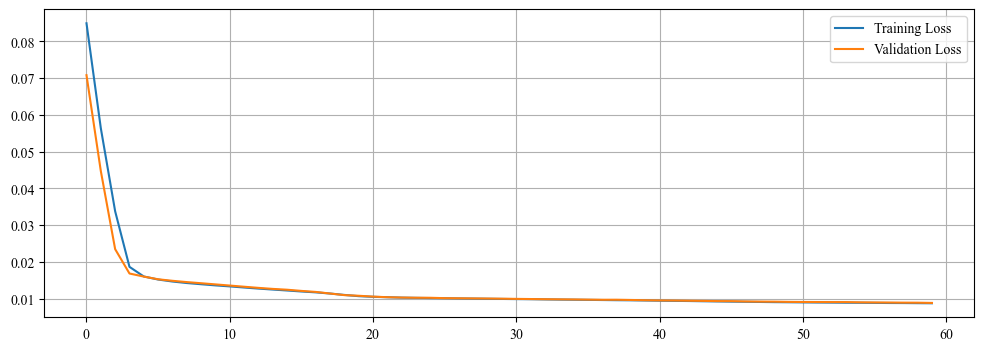

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid(True)
plt.legend()

## Reconstruction error
Let's first examine how well the model reconstructs the normal data before attempting to detect anomalies in the abnormal signals.

In [14]:
predictions = autoencoder.predict(X_val)
val_mse = np.square(X_val - predictions)

# Calcular o MSE médio
mse_mean = val_mse.mean()

print(f'MSE médio dos dados de validação: {mse_mean.mean()}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE médio dos dados de validação: 0.00910037586311752


In [20]:
mse_mean[2]

0.02221901833687591

In [26]:
def plot_reconstruction(model, test_data, sample_index):

    encoded_data = model.encoder(test_data).numpy()
    decoded_data = model.decoder(encoded_data).numpy()
    test_data = scaler.inverse_transform(test_data)
    decoded_data = scaler.inverse_transform(decoded_data)
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_index], 'b', label="Input")
    plt.plot(decoded_data[sample_index], 'r', label="Reconstruction")
    plt.fill_between(np.arange(len(test_data[sample_index])), decoded_data[sample_index], test_data[sample_index], color='lightcoral', label="Error")
    plt.title('Vanilla AE', size =14)
    plt.xlabel('Time [s]')
    plt.xlabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

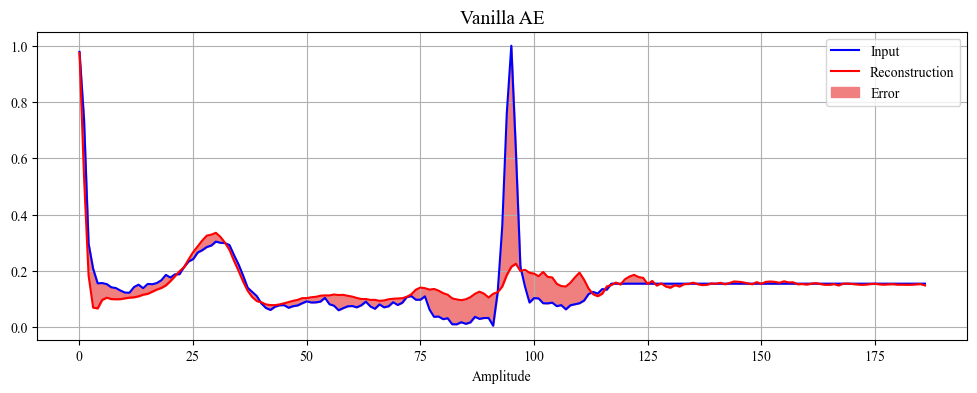

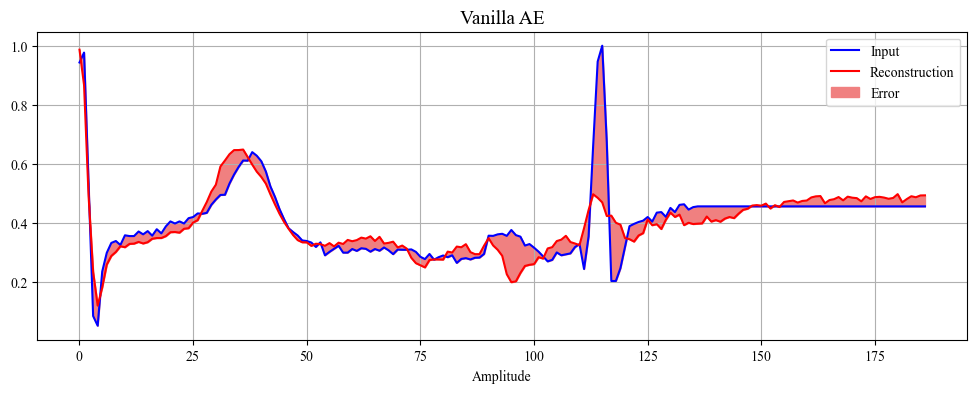

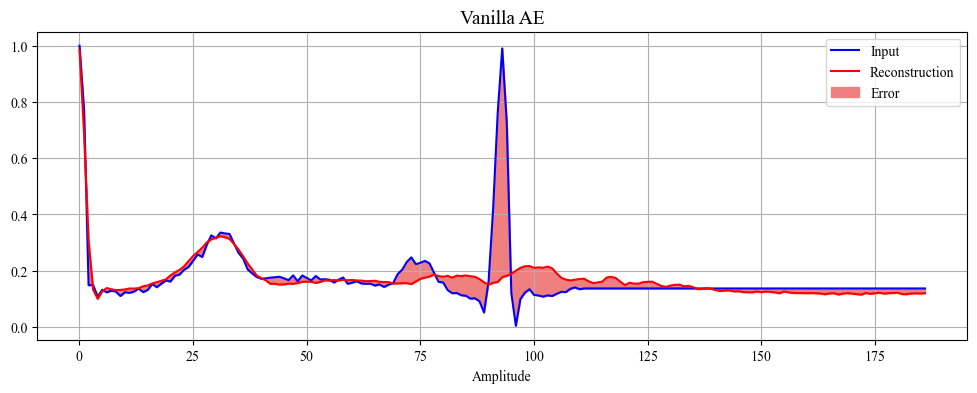

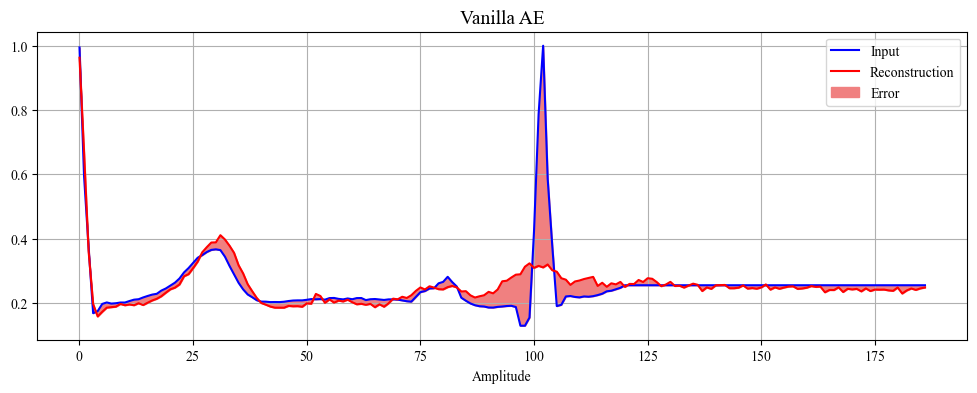

In [27]:
for i in range(1,5):
    plot_reconstruction(autoencoder, val_data, sample_index=i)

The model struggles to accurately reconstruct the rising peaks in the middle of the signals, which is concerning as it may incorrectly classify any peak as an anomaly